In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [68]:
kharpov = True

In [98]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'log_scale': np.log(252 * 1.564e-5),
               'log_delta': np.log(0.6475),
               'rho': .5,
              }
else:
     true_params ={'log_delta': -1.42,
                   'rho':0.69,
                   'log_scale': 1.85,
                   'phi': -.3,
                   'pi': -.07,
                   'theta': .42}
    
time_dim = 3700
sim_dim = 1000
innov_dim = 250

In [99]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [100]:
def compute_moments(log_delta, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_scale +  log_delta) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_delta)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_delta=log_delta, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [101]:
compute_moments(**true_params)

{'return_mean': -0.007050616648866135,
 'return_var': 0.0052238452423708105,
 'vol_mean': 0.005103957600000001,
 'vol_var': 4.023225201945602e-05}

In [102]:
vl.compute_gamma(**true_params)

-0.006374894575242154

In [103]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'log_delta': -0.4346364854084443,
 'rho': 0.5,
 'gamma': -0.006374894575242154,
 'beta': -1.2876318052072655,
 'psi': 1.155240016994922,
 'zeta': 0.9999}

In [104]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'log_delta': -0.4346364854084443,
 'rho': 0.5}

In [105]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'log_delta': -0.4346364854084443,
 'rho': 0.5,
 'gamma': -0.006374894575242154,
 'beta': -1.2876318052072655,
 'psi': 1.155240016994922,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [106]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [107]:
data.corr()

,vol,rtn
vol,1.000000,-0.007444
rtn,-0.007444,1.000000


In [108]:
data.vol.var()

3.9030929901409005e-05

In [109]:
init_constants = vl.compute_init_constants(data.vol)

In [110]:
init_constants

{'rho': 0.5135731513440555,
 'log_scale': -5.556079573908835,
 'log_delta': -0.4804236610939334}

In [111]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_delta': -0.44080129723744826,
  'log_scale': -5.549831600731183,
  'rho': 0.4877961255437741},
            log_delta  log_scale       rho
 log_delta   0.001359  -0.000736 -0.000299
 log_scale  -0.000736   0.001490 -0.000164
 rho        -0.000299  -0.000164  0.000433)

In [112]:
omega, omega_cov = vl.estimate_params(data)

In [113]:
omega

{'gamma': -0.006782431852391713,
 'beta': -1.23531807686568,
 'psi': 1.0829293775803597,
 'zeta': 1.0230022808428063,
 'log_delta': -0.44080129723744826,
 'log_scale': -5.549831600731183,
 'rho': 0.4877961255437741}

In [114]:
omega_cov

,beta,gamma,log_delta,log_scale,psi,rho,zeta
beta,0.004859,-1.388131e-05,0.000000,0.000000,-0.002034,0.000000,0.000000
gamma,-0.000014,1.097248e-07,0.000000,0.000000,-0.000008,0.000000,0.000000
log_delta,0.000000,0.000000e+00,0.001359,-0.000736,0.000000,-0.000299,0.000000
log_scale,0.000000,0.000000e+00,-0.000736,0.001490,0.000000,-0.000164,0.000000
psi,-0.002034,-8.449570e-06,0.000000,0.000000,0.060087,0.000000,0.000000
rho,0.000000,0.000000e+00,-0.000299,-0.000164,0.000000,0.000433,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000538


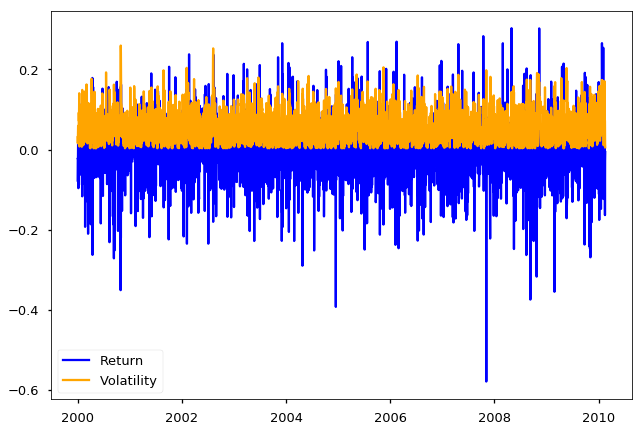

In [115]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [116]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.00151,0.000020
rtn,0.00002,0.004787


In [117]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'log_delta': -0.4346364854084443,
 'rho': 0.5,
 'gamma': -0.006374894575242154,
 'beta': -1.2876318052072655,
 'psi': 1.155240016994922,
 'zeta': 0.9999}

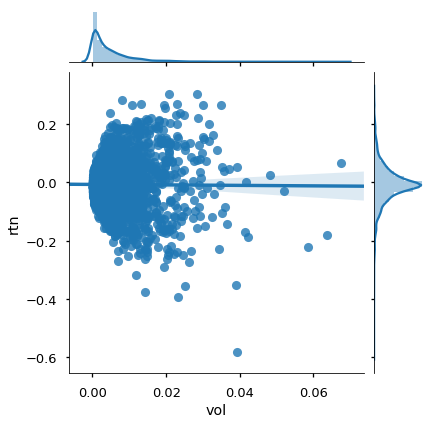

In [118]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [119]:
data.describe()

,vol,rtn
count,3700.000000,3700.000000
mean,0.004912,-0.007550
std,0.006247,0.069188
min,0.000010,-0.579644
25%,0.000750,-0.036691
50%,0.002738,-0.008527
75%,0.006622,0.023223
max,0.067466,0.303146


## I now estimate all of the parameters

In [120]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [121]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [122]:
vol_estimator(data_arr[2])

({'log_delta': -0.42586221307712446,
  'log_scale': -5.4886744602883,
  'rho': 0.4848556572099835},
            log_delta  log_scale       rho
 log_delta   0.001415  -0.000722 -0.000359
 log_scale  -0.000722   0.001377 -0.000112
 rho        -0.000359  -0.000112  0.000442)

In [123]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [124]:
vol_params = pd.Series(true_params).loc[['log_delta', 'log_scale', 'rho']]

In [125]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

(0, 20)

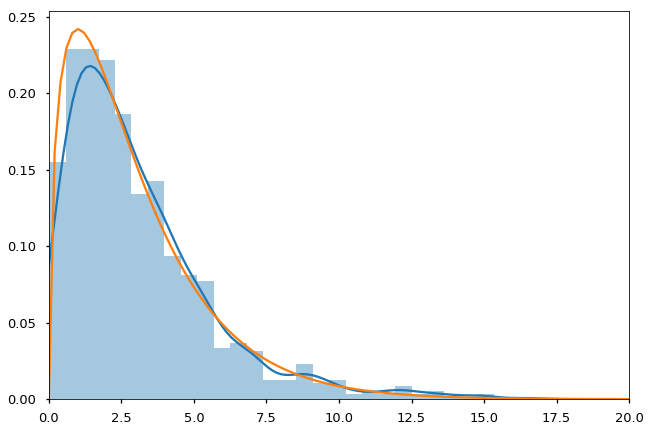

In [126]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3))
vol_ax.set_xlim([0,20])

In [127]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [129]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [130]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [131]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_delta=true_params['log_delta'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

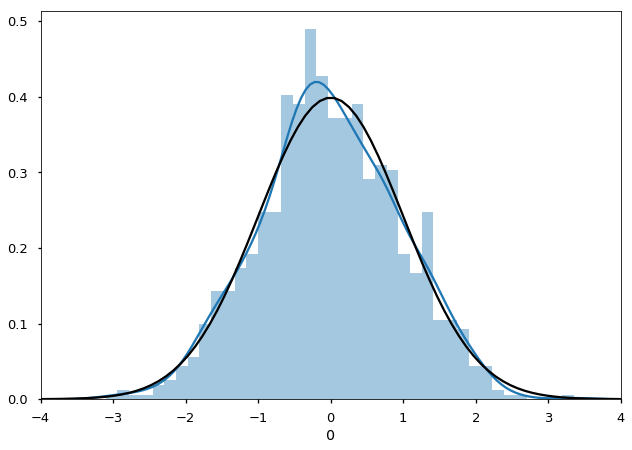

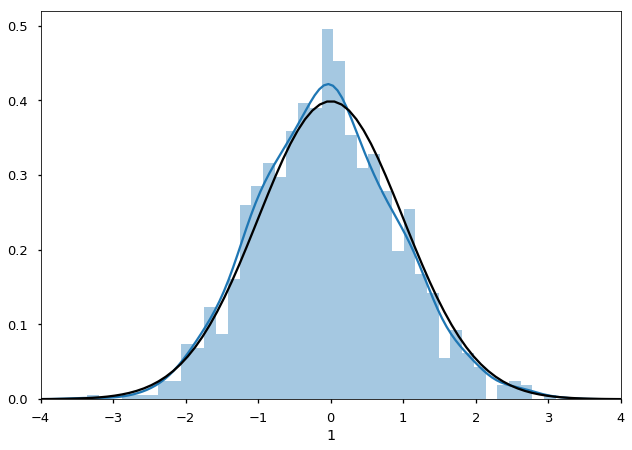

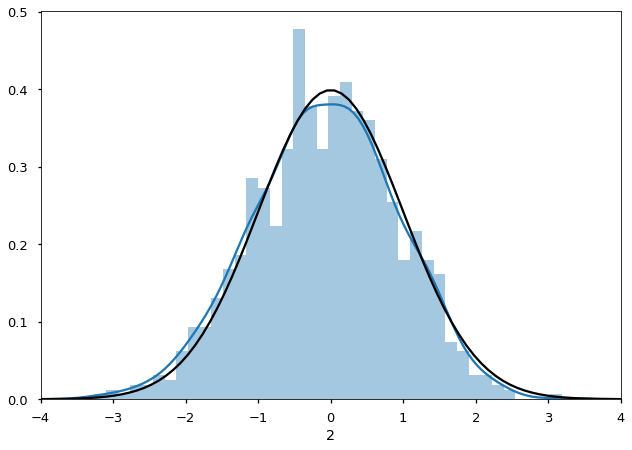

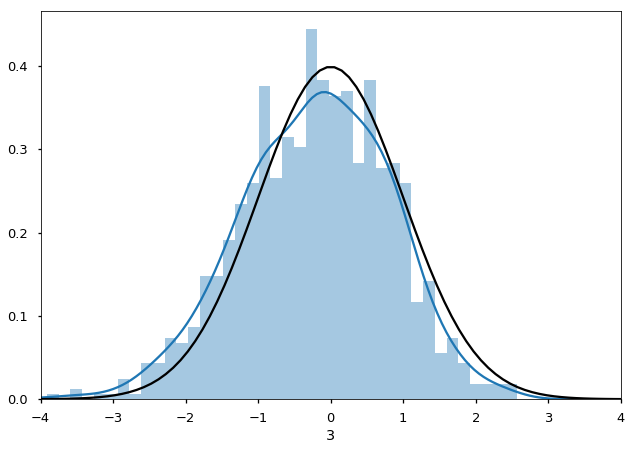

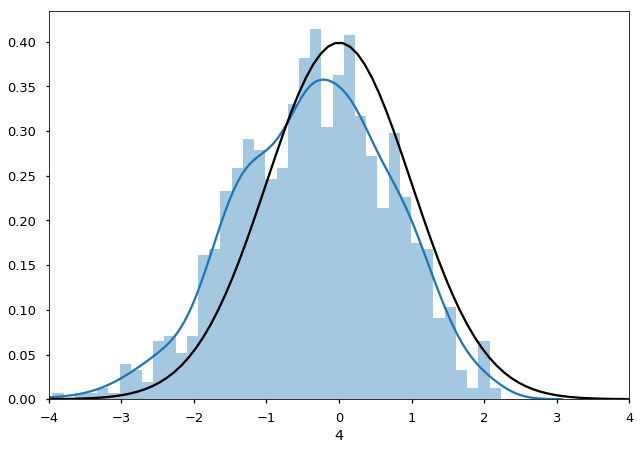

In [132]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

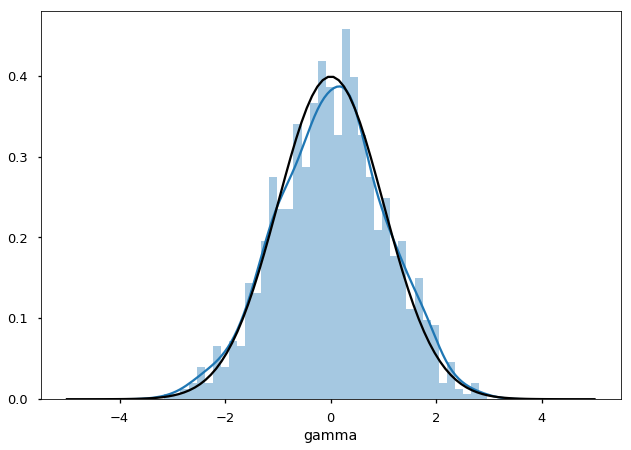

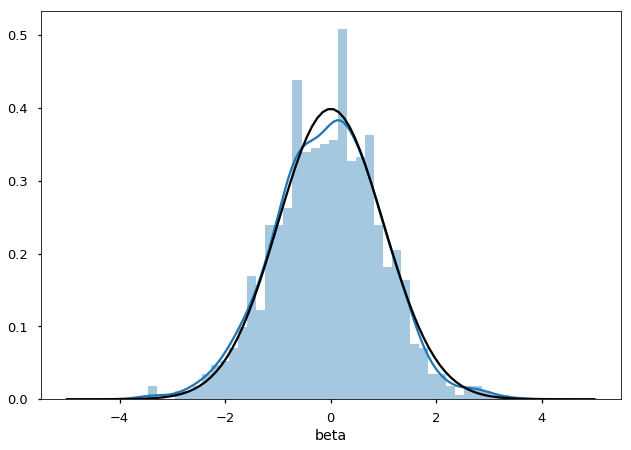

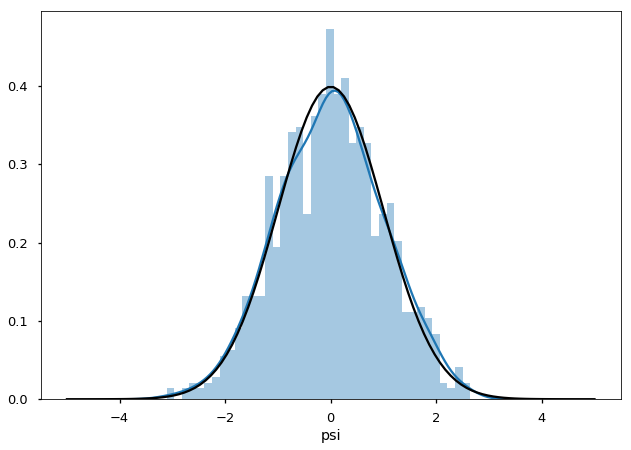

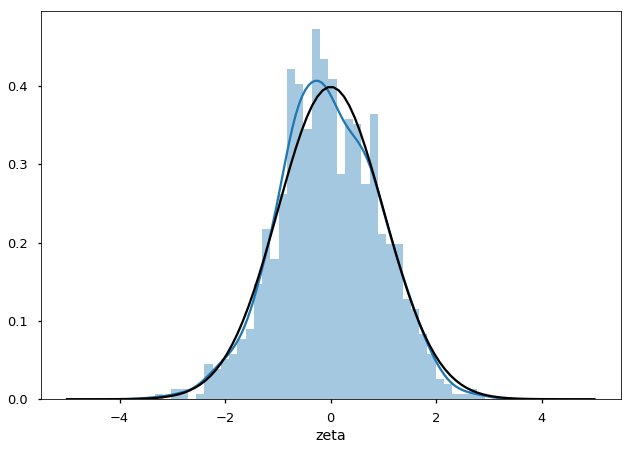

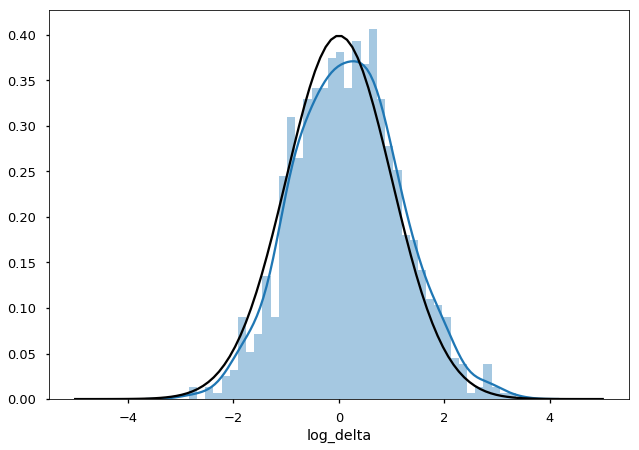

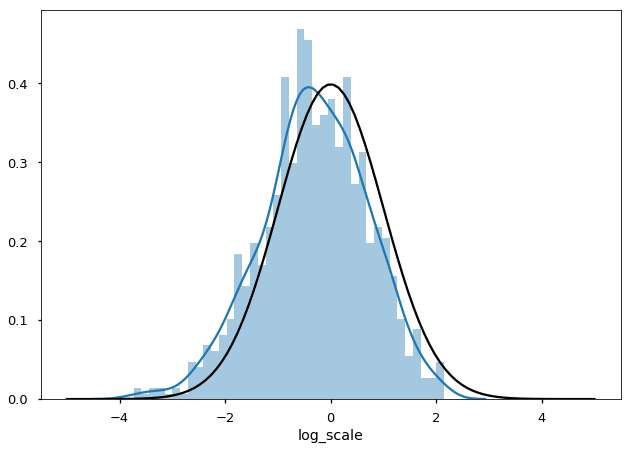

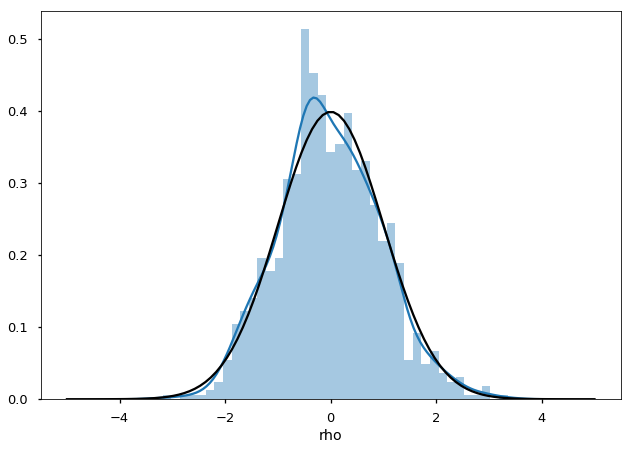

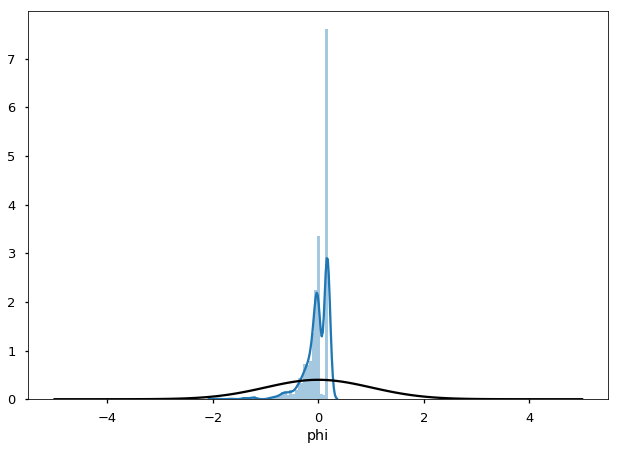

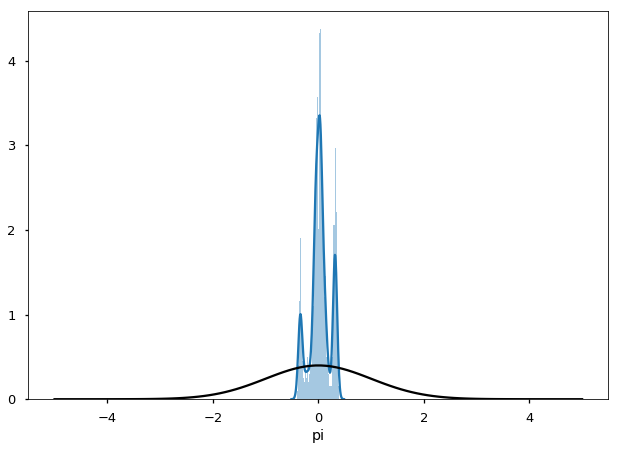

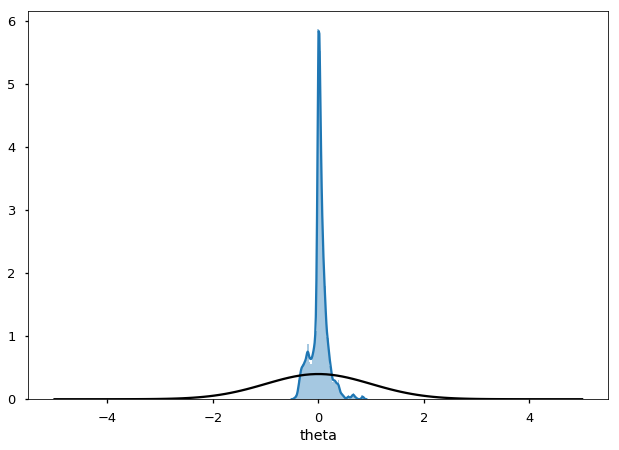

In [133]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

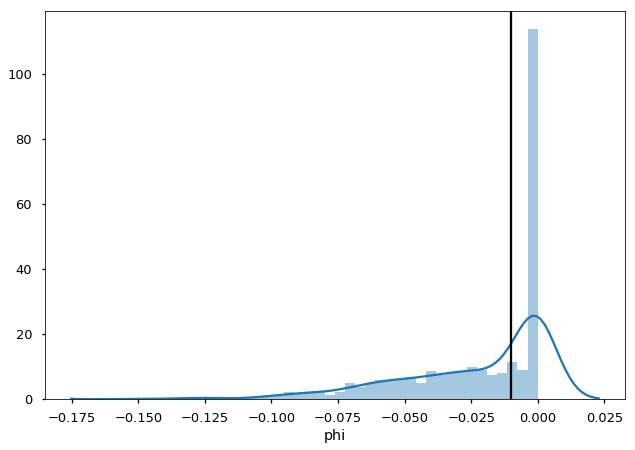

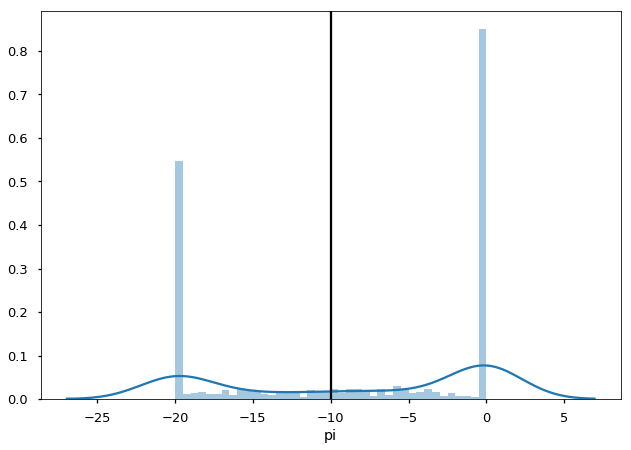

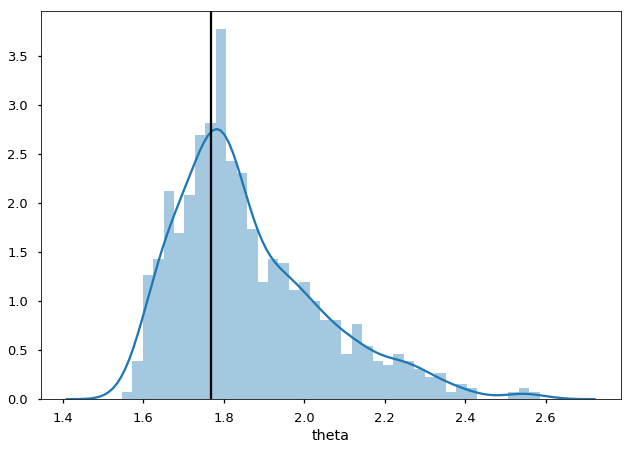

In [134]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [135]:
omega


{'gamma': -0.006782431852391713,
 'beta': -1.23531807686568,
 'psi': 1.0829293775803597,
 'zeta': 1.0230022808428063,
 'log_delta': -0.44080129723744826,
 'log_scale': -5.549831600731183,
 'rho': 0.4877961255437741}

In [136]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'log_delta': -0.4346364854084443,
 'rho': 0.5}

In [137]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [138]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [139]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

array([-5.798e-02,  2.135e-04,  2.259e-01,  1.144e-02])

In [140]:
vl._link_grad_in1(*true_prices, **omega)

array([[ 1.   ,  0.   ,  0.   ,  0.107,  0.   ,  2.564,  0.   ],
       [ 0.   ,  1.   ,  0.006,  0.007,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.058,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -1.   ]])

In [141]:
compute_ar(est_arr[0])

1.5185026911735473

In [142]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

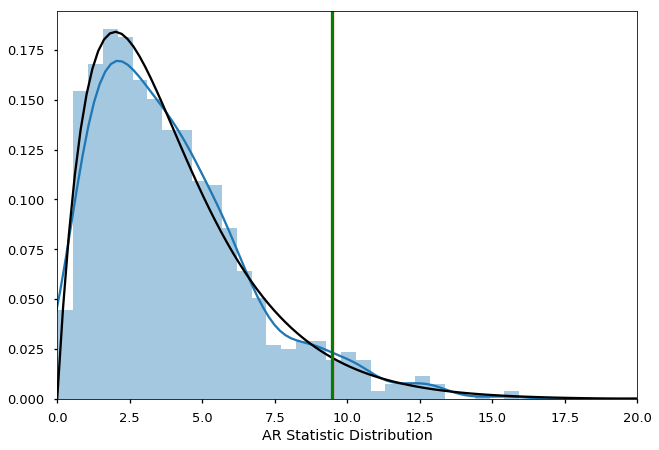

In [143]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
# returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
#                                         robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)